In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import logging
import random
from pathlib import Path
from typing import Any

import torch
import torchvision as tv
from PIL import Image
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision.models.detection import fcos
from torchvision.transforms import v2 as v2
from tqdm import tqdm

import bb
import tt

LOG = logging.getLogger(__name__)
tt.logging_init()

SEED = 325
tt.seed(SEED)

In [ ]:
data_path = Path.home() / "src/data"
mc_data_path = data_path / "minecraft/info.json"
dset = bb.Dataset.load(mc_data_path)
torch_root = data_path / "torchvision"

# bb.TorchDataset

In [ ]:
tdset = bb.TorchDataset(data_path / "minecraft")
tdset

In [ ]:
loader = DataLoader(tdset, batch_size=8, collate_fn=bb.TorchDataset.collate_fn)
images, targets = next(iter(loader))
result = tv.utils.make_grid(
    [bb.torch_plot_bb(img, target, tdset.categories) for img, target in zip(images, targets)], nrow=2
)
v2.functional.to_pil_image(result)

In [ ]:
img, target = tdset[10]
categories = tdset.dset.categories
label_names = [categories[label.item()] for label in target["labels"]]
result = bb.torch_plot_bb(img, target, tdset.categories)
v2.functional.to_pil_image(result)

# Minecraft COCO

In [ ]:
# Convert internal format to coco
dset = bb.Dataset.load(mc_data_path)
dset.to_coco(data_path / "coco/minecraft", add_background=True)

In [ ]:
# https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_transforms_e2e.html

IMAGES_PATH = data_path / "coco/minecraft/images"
ANNOTATIONS_PATH = data_path / "coco/minecraft/annotations.json"
coco_dataset = tv.datasets.wrap_dataset_for_transforms_v2(
    # The transforms can be v2 since they're handled by the wrapper.
    tv.datasets.CocoDetection(IMAGES_PATH, ANNOTATIONS_PATH, transforms=v2.ToImage())
)

coco_categories = {
    cat["id"]: cat["name"] for cat in coco_dataset.coco.loadCats(coco_dataset.coco.getCatIds())
}
print(coco_categories)

In [ ]:
img, target = coco_dataset[0]
label_names = [coco_categories[label.item()] for label in target["labels"]]
print(target)
print(label_names)
v2.ToPILImage()(img)

# MCDataset

In [ ]:
BATCH_SIZE = 16
TRAIN_PCT = .85

mcd_root = data_path / "coco/minecraft"
mcd = bb.MCDataset(mcd_root)
train_dset, valid_dset = tt.split1(mcd, TRAIN_PCT, SEED)
# bb.plot_bb_grid(images, targets, mcd.categories)

train_loader = DataLoader(
    train_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
valid_loader = DataLoader(
    valid_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(train_dset)}, n_valid={len(valid_dset)}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
n_train=346, n_valid=62


# Fine Tune

In [16]:
class Trainer:

    def __init__(self, *, train_loader: DataLoader, categories: list[str], device="mps") -> None:
        self.train_loader = train_loader
        self.categories = categories
        self.device = torch.device(device)

        self.weights = fcos.FCOS_ResNet50_FPN_Weights.COCO_V1
        self.preprocess = self.weights.transforms()
        self.model = fcos.fcos_resnet50_fpn(weights=self.weights)

        # After the model weights are loaded, replace the categories and the classification head
        # self.weights.meta["categories"] = categories
        # Conv2d(256, 91, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        num_classes = len(categories)
        self.orig_cls_logits = self.model.head.classification_head.cls_logits
        self.model.head.classification_head.cls_logits = torch.nn.Conv2d(
            256, num_classes, kernel_size=3, stride=1, padding=1
        )
        self.model.head.classification_head.num_classes = num_classes

        # Move to device after head is replaced
        self.model = self.model.to(device)

        for param in self.model.parameters():
            param.requires_grad_(False)
        for param in self.model.head.classification_head.cls_logits.parameters():
            param.requires_grad_(True)
        self.optimizer = torch.optim.AdamW(params=self.model.parameters(), lr=1e-4)

    def infer(self, img: tv.tv_tensors.Image) -> Image.Image:
        self.model.eval()
        img = img.to(self.device)
        batch = [self.preprocess(img)]
        with torch.inference_mode():
            prediction = self.model(batch)[0]
        print(f"prediction: {prediction}")
        labels = [self.categories[i] for i in prediction["labels"]]
        box = tv.utils.draw_bounding_boxes(
            img,
            boxes=prediction["boxes"],
            labels=labels,
            colors="red",
            width=4,
            font="/System/Library/Fonts/Helvetica.ttc",  # macOS
            font_size=20,
        )
        return v2.functional.to_pil_image(box.detach())

    def train_one_epoch(self):
        self.model.train()

        for images, targets in tqdm(self.train_loader):
            images = images.to(self.device)
            targets = [
                {
                    # Handle images with no boxes
                    "boxes": t.get("boxes", torch.zeros(0, 4)).to(self.device),
                    "labels": t.get("labels", torch.zeros(0, dtype=torch.int64)).to(
                        self.device
                    ),
                }
                for t in targets
            ]

            # Forward pass of image through network and get output
            batch = self.preprocess(images)
            # torchvision models return loss in train mode.
            loss_dict = self.model(batch, targets)
            loss = sum(loss_dict.values())

            # Zero gradients
            self.optimizer.zero_grad()

            # Backpropagate gradients
            loss.backward()
            # Do a single optimization step
            self.optimizer.step()


img = mcd[0][0]
trainer = Trainer(train_loader=train_loader, categories=mcd.categories)

prediction: {'boxes': tensor([[1.5891e+02, 1.0319e+02, 3.5433e+02, 2.8092e+02],
        [0.0000e+00, 2.6555e+02, 7.9831e+01, 3.4669e+02],
        [0.0000e+00, 2.4247e+02, 3.4074e+02, 5.9471e+02],
        [1.3154e+02, 1.0211e+02, 3.3632e+02, 3.4847e+02],
        [3.3921e+02, 4.9582e+02, 4.1713e+02, 5.5912e+02],
        [4.3997e+02, 5.4431e+02, 5.1342e+02, 6.3359e+02],
        [1.3988e+00, 1.6623e+02, 1.7024e+02, 2.9042e+02],
        [3.3459e-01, 1.0088e+01, 1.4491e+02, 1.9463e+02],
        [1.5891e+02, 1.0319e+02, 3.5433e+02, 2.8092e+02],
        [1.2873e+01, 5.6480e+02, 9.0186e+01, 6.2809e+02],
        [4.8763e+02, 4.0208e+00, 6.3746e+02, 1.6274e+02],
        [1.5177e+02, 3.5302e+02, 4.6359e+02, 6.2274e+02],
        [5.1358e+02, 5.5379e+02, 6.0626e+02, 6.2971e+02],
        [1.6417e+02, 1.0718e+02, 2.5567e+02, 1.8689e+02],
        [1.6987e+02, 1.6973e+02, 3.3057e+02, 3.3582e+02],
        [1.7209e+02, 1.7377e+02, 3.5598e+02, 3.4740e+02],
        [1.4487e+02, 5.4950e+02, 2.0288e+02, 6.207

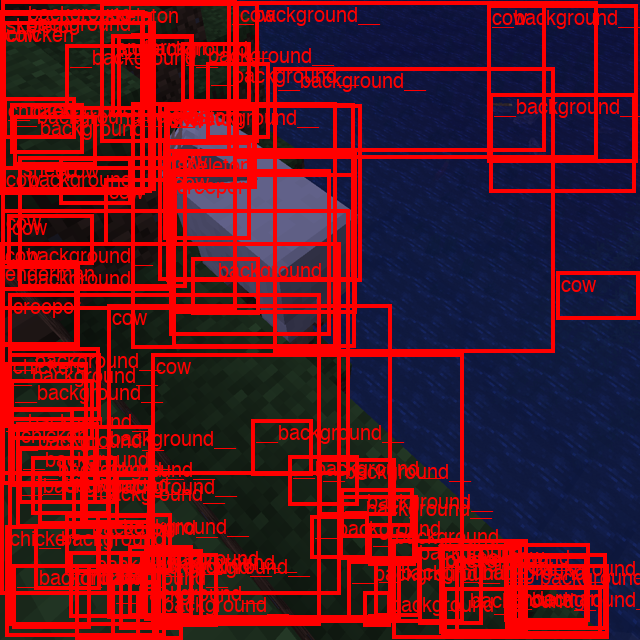

In [19]:
trainer.infer(img)

In [18]:
trainer.train_one_epoch()

100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


In [ ]:
images, targets = next(iter(train_loader))
trainer.preprocess(images).shape